# Grad-Cam on BirdNET custom model

## Load libraries

First of all, we need to load the libraries that we will use in this notebook.

Main uses we will give to these libraries are data manipulation, data visualization, audio processing and deep learning model training. Also, to improve model analysis,  we will use libraries to log and save model training and evaluation.

In [2]:
import os

# Data
import numpy as np
import pandas as pd

# Audio
import librosa
import librosa.display
from pydub import AudioSegment

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Performance Metrics and Model Selection
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger, ReduceLROnPlateau
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report

# Deep Learning Visualization
from sklearn.metrics import confusion_matrix

2025-03-18 09:26:35.309956: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 09:26:35.867247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-18 09:26:35.867408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-18 09:26:35.974802: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-18 09:26:36.210360: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-18 09:26:36.214512: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
SEED = 42

## Preprocess Audios

First of all, we need to preprocess the audios. We have the audios in folders in different sampling rate. And might have different durations. We need to preprocess them to have the same duration and sampling rate.

We will use BirdNET as a pre-trained model to classify the audios. BirdNET is a deep learning model that classifies bird sounds. We will use it to classify marine mammals sounds. In recent research it has been demonstrated that [global birdsong embeddings enable superior transfer learning for bioacoustic classification](https://www.nature.com/articles/s41598-023-49989-z). BirdNET and Perch are the best performance models for all the datasets used in the research. For this reasen we will focus on one of those models, BirdNET.

BirdNET takes 3 second windwos as input as most calls and songs of different species are 3 seconds. This is the target duration we will use for the audios.

Our target data sampling rate was 256000 Hz but BirdNET takes 48000 Hz, so 48000 Hz will be used. It just changes the resolution of the audio. Also, some audios from Watkins Marine Mammals are undersampled (500-1000 Hz) making it complete silence above those frequencies which is not the case in the original audio.

In [4]:
# Function to preprocess audio
def preprocess_audio(file_path, target_sr=48000, duration=3, min_duration = 1, df_background=None, fill_mode='silence'):
    fill_modes = ['silence', 'background', 'repeat', 'noise', 'random']
    # Ensure fill_silence_mode is valid (either 'silence', 'background', 'repeat' or 'random') if not print and set to 'silence'
    if fill_mode not in fill_modes:
        print(f"Invalid fill_silence_mode: {fill_mode}. Setting to 'silence'. Valid options are {fill_modes}.")
        fill_mode = 'silence'
        # If fill_mode is 'background' and no background data is provided, set to 'silence'
        if fill_mode == 'background' and df_background is None:
            print(f"No background data provided. Setting fill_mode to 'silence'.")
            fill_mode = 'silence'
    
    # Load audio
    signal, _ = librosa.load(file_path, sr=target_sr, mono=True)
    # resample to target_sr
    # signal = librosa.resample(signal, orig_sr=sr, target_sr=target_sr)
    
    # Calculate the maximum length in samples and min length in samples
    max_length = target_sr * duration  # e.g., 48000 * 3
    min_length = target_sr * min_duration  # e.g., 48000 * 1
    
    # If the signal is shorter than the desired max length, fill with the selected option
    if len(signal) < max_length:

        if fill_mode == "random":
            fill_mode = np.random.choice(['silence', 'background', 'repeat', 'noise'])
        elif fill_mode == "silence":
            padding = max_length - len(signal)
            pad_left = padding // 2
            pad_right = padding - pad_left
            signal = np.pad(signal, (pad_left, pad_right), mode='constant')
        elif fill_mode == "background":
            # Randomly select a background audio file
            # take one random background file
            background_file = df_background.sample(SEED)["File"].values[0]
            background_signal, _ = librosa.load(background_file, sr=target_sr, mono=True)
            # resample to target_sr
            # background_signal = librosa.resample(background_signal, orig_sr=sr, target_sr=target_sr)
            background_signal = background_signal[:max_length]
            # Fill silence in time with background signal
            padding = max_length - len(signal)
            pad_left = padding // 2
            pad_right = padding - pad_left
            # signal = background + signal + background
            signal = np.pad(signal, (pad_left, pad_right), mode='constant')
            # signal[signal <= 0.0] = background_signal[signal <= 0.0]
            signal = signal*0.3 + background_signal*0.7
        elif fill_mode == "repeat":
            repeats = max_length // len(signal)
            remainder = max_length % len(signal)
            signal = np.concatenate([signal] * repeats + [signal[:remainder]])
        elif fill_mode == "noise":
            noise = np.random.normal(0, 0.01, len(signal))
            # Fill only where it is silence
            signal = signal + noise

        return signal
    
    # If the signal is longer than the desired length, split into 3-second windows
    elif len(signal) > max_length:
        segments = []

        # take first 3 seconds
        segments.append(signal[:max_length])

        # take middle 3 seconds
        mid_start = len(signal) // 2 - max_length // 2
        segments.append(signal[mid_start:mid_start + max_length])

        # take last 3 seconds
        segments.append(signal[-max_length:])

        signal = segments[1]

        # return middle segment
        return signal
    
    # If the signal is exactly the desired length, return as is
    else:
        _, orig_sr = librosa.load(file_path, mono=True)
        # if signal sr is not target_sr, fill with background
        # if orig_sr != target_sr:
        #     background_file = df_background.sample()["File"].values[0]
        #     background_signal, _ = librosa.load(background_file, sr=target_sr, mono=True)
        #     background_signal = background_signal[:max_length]
        #     signal = signal*0.9 + background_signal*0.1

        return signal

# Data Generators

## Data Augmentation

In [5]:
import librosa
import matplotlib.pyplot as plt

def add_noise(signal, noise_factor=0.005):
    noise = np.random.randn(signal.shape[0])
    augmented_signal = signal + noise_factor * noise
    return augmented_signal

def shift_time(signal, shift_max=0.9):
    shift = np.random.randint(int(shift_max * len(signal)))
    augmented_signal = np.roll(signal, shift)
    return augmented_signal

# Mix Up
def mix_up(signal1, signal2, alpha=0.5):
    mixed_signal = alpha * signal1 + (1 - alpha) * signal2
    return mixed_signal

# Check data augmentation in the same audio, plot the original and the augmented audio with each of the changes
# Load the audio file
# sample_file = df_train['File'][0]
# sample_file_1 = df_train['File'][1]
# signal, sr = librosa.load(sample_file, sr=48000)
# signal_1, sr_1 = librosa.load(sample_file_1, sr=48000)

# # preprocess the audio
# signal = preprocess_audio(sample_file, target_sr=48000, duration=3)
# signal_1 = preprocess_audio(sample_file_1, target_sr=48000, duration=3)

# # Add noise
# augmented_signal_noise = add_noise(signal, noise_factor=0.005)

# # Shift time
# augmented_signal_shift = shift_time(signal, shift_max=0.2)

# # Mix up
# augmented_signal_mix_up = mix_up(signal, signal_1, alpha=0.5)

# # Mel spectrograms
# mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=48000)
# mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# mel_spectrogram_noise = librosa.feature.melspectrogram(y=augmented_signal_noise, sr=48000)
# mel_spectrogram_noise = librosa.power_to_db(mel_spectrogram_noise, ref=np.max)

# mel_spectrogram_shift = librosa.feature.melspectrogram(y=augmented_signal_shift, sr=48000)
# mel_spectrogram_shift = librosa.power_to_db(mel_spectrogram_shift, ref=np.max)

# mel_spectrogram_mix_up = librosa.feature.melspectrogram(y=augmented_signal_mix_up, sr=48000)
# mel_spectrogram_mix_up = librosa.power_to_db(mel_spectrogram_mix_up, ref=np.max)

# # Visualize mel spectrogram
# plt.figure(figsize=(40, 8))
# plt.subplot(1, 4, 1)
# librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Original ({df_train["Class"][0]})', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 2)
# librosa.display.specshow(mel_spectrogram_noise, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Noise', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 3)
# librosa.display.specshow(mel_spectrogram_shift, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Shift', fontsize=20)
# plt.tight_layout()

# plt.subplot(1, 4, 4)
# librosa.display.specshow(mel_spectrogram_mix_up, sr=48000, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title(f'Mix Up with {df_train["Class"][1]}', fontsize=20)
# plt.tight_layout()

In [6]:
def audio_data_generator(df, classes_list, classes_mapping, batch_size=32, target_sr=48000, duration=3, augment=False, df_background=[]):
    while True:
        X, y = [], []
        # shuffle the dataframe
        df = shuffle(df)
        # reset index
        df = df.reset_index(drop=True)
        for _, row in df.iterrows():
            file_path = row['File']
            cls_index = classes_mapping[row['Class']] # Ensure it is the same classes mapping
            signal = preprocess_audio(file_path, target_sr, duration)
            # print(f"File: {file_path}, Class: {row['Class']}, Signals: {len(signals)}")
            if augment:
                if np.random.rand() < 0.5:
                    signal = add_noise(signal)
                if np.random.rand() < 0.5:
                    signal = shift_time(signal)
                if np.random.rand() < 0.5:
                    # If background noise is provided
                    if len(df_background) > 0:
                        # random background noise
                        random_noise = df_background['File'][np.random.randint(0, len(df_background))]
                        signal_1 = preprocess_audio(random_noise, target_sr=48000, duration=3)
                        # signal_1 = noise_signals[np.random.randint(0, len(noise_signals))]
                        signal = mix_up(signal, signal_1, alpha=np.random.uniform(0, 0.7))
                    else:
                        signal_1 = preprocess_audio(df['File'][np.random.randint(0, len(df))], target_sr=48000, duration=3)
                        signal = mix_up(signal, signal_1, alpha=0.5)
            
            X.append(signal)
            y.append(cls_index)
            
            if len(X) == batch_size:
                X = np.array(X)
                y = np.array(y)
                X, y = shuffle(X, y)
                y = to_categorical(y, num_classes=len(classes_list))
                # print(f"Batch X shape: {X.shape}, y shape: {y.shape}")
                yield X, y
                X, y = [], []

def audio_data_generator_test(df, classes_list, classes_mapping, batch_size=32, target_sr=48000, duration=3):
    while True:
        XPath, XSignal, y = [], [], []
        for _, row in df.iterrows():
            file_path = row['File']
            cls_index = classes_mapping[row['Class']]
            signal = preprocess_audio(file_path, target_sr, duration)
            XPath.append(file_path)
            # X_segment.append(i)
            XSignal.append(signal)
            y.append(cls_index)
            
            if len(XSignal) == batch_size:
                XSignal = np.array(XSignal)
                y = np.array(y)
                yield XPath, XSignal, to_categorical(y, num_classes=len(classes_list))
                XPath, XSignal, y = [], [], []

# Test the generator with test_Df
# test_gen = audio_data_generator(df_test, CLASSES, CLASSES_MAPPING, batch_size=8, target_sr=48000, duration=3)
# X, y = next(test_gen)
# print(X.shape, y.shape)

# Model Functions

In [7]:
import warnings
warnings.filterwarnings('ignore')

def load_base_model(model_path = 'BirdNET-Analyzer-V2.4/V2.4/BirdNET_GLOBAL_6K_V2.4_Model/', freeze = True, n_freeze = 4, classes=[]):
    model = tf.keras.models.load_model(model_path, compile=False).model

    # Get the output of the second to last layer
    output_layer = model.layers[-2].output

    # Add 3 dense layers: 512, 128 and len(classes)

    # Add a dense layer with 512 units and ReLU activation
    x = tf.keras.layers.Dense(256, activation='relu')(output_layer)

    # Add a dense layer with 128 units and ReLU activation
    x = tf.keras.layers.Dense(64, activation='relu')(x)

    # Add a dense layer with the number of classes and softmax activation
    output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(x)

    # output_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(model.output)

    # Create a new model
    model = tf.keras.models.Model(inputs=model.input, outputs=output_layer)

    # Compile
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'])

    if freeze:
        # Freeze first layers
        for layer in model.layers[:-n_freeze]:
            layer.trainable = False

    print(model.summary())

    return model

def model_compile(model, optimizer = "adam", loss = "categorical_crossentropy", metrics = ['accuracy']):
    # Compile
    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=metrics,
        ) 
    
    return model

def train_model(model, df_train, df_val, classes, classes_mapping, batch_size=8, target_sr=48000, duration=3, epochs=100, callbacks=None, doshuffle=True, doDataAugmentation=False, df_background=[]):
    # Training and Validation Generators

    # shuffle data
    if doshuffle:
        df_train = shuffle(df_train, random_state=42)
        df_val = shuffle(df_val, random_state=42)

    train_gen = audio_data_generator(df_train, classes, classes_mapping, batch_size=batch_size, target_sr=target_sr, duration=duration, augment=doDataAugmentation, df_background=df_background)
    val_gen = audio_data_generator(df_val, classes, classes_mapping, batch_size=batch_size, target_sr=target_sr, duration=duration)

    total_segments_train = df_train['Duration'].sum() // duration
    total_segments_val = df_val['Duration'].sum() // duration

    # Calculate steps per epoch and validation steps
    steps_per_epoch = total_segments_train // batch_size
    validation_steps = total_segments_val // batch_size

    # Train the model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        shuffle=doshuffle,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def plot_training_monitoring(history):
    # Plot accuracy and loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")

    plt.show()

def evaluate_model(model, df_test, classes, classes_mapping, reverse_classes_mapping, batch_size=1, target_sr=48000, duration=3, plot_confusion_matrix=True):
    # Evaluate on test data
    # calculate total segments of 3 seconds in df_Test (summatory of Duration of each file) / 3
    test_gen = audio_data_generator(df_test, classes, classes_mapping, batch_size=batch_size)

    total_segments = len(df_test)

    test_steps = total_segments // batch_size

    results = model.evaluate(test_gen, steps=test_steps)
    print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

    # predict all samples of df_test and get XPath, X_segment, XSignal, y_true and y_predicted
    test_gen = audio_data_generator_test(df_test, classes, classes_mapping, batch_size=batch_size)
    y_true = []
    y_predicted = []
    XPath = []
    # X_segment = []
    XSignal = []

    for i in range(test_steps):
        XPath_batch, XSignal_batch, y_true_batch = next(test_gen)
        y_predicted_batch = model.predict(XSignal_batch, verbose=0)
        y_true.append(y_true_batch)
        y_predicted.append(y_predicted_batch)
        XPath.extend(XPath_batch)
        # X_segment.extend(X_segment_batch)
        XSignal.extend(XSignal_batch)

    y_true = np.vstack(y_true)
    y_predicted = np.vstack(y_predicted)

    # Get the predicted classes and confidence
    y_pred_classes = np.argmax(y_predicted, axis=1)
    y_pred_confidence = np.max(y_predicted, axis=1)

    y_pred = np.vstack((y_pred_classes, y_pred_confidence))
    y_true = np.argmax(y_true, axis=1)

    # Accuracy manual
    # accuracy_manual = np.mean(y_pred_classes == y_true)
    # print(f"Accuracy from model.evaluate: {results[1]}")
    # print(f"Manual accuracy: {accuracy_manual}")

    if plot_confusion_matrix:
        # Plot confusion matrix
        cm = confusion_matrix(y_true, y_pred_classes)
        plt.figure(figsize=(30, 30))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        # Normalized by rows
        cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
        plt.figure(figsize=(30, 30))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
        plt.title('Normalized Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    # Put together X_eval, y_true, y_pred_classes, y_pred_confidence
    df_results = pd.DataFrame({
        'Path': list(XPath),
        # 'SegmentIdx': list(X_segment),
        'Signal': list(XSignal),
        'True': y_true,
        'Predicted': y_pred_classes,
        'PredictedClass': [reverse_classes_mapping[p] for p in y_pred_classes],
        'Confidence': y_pred_confidence
    })

    return df_results

# Experiment: Only Strait of Gibraltar Classes + BG ST Gibraltar + Data Augmentation

## Dataset

### Final Dataset

In [8]:
# Read dataset CSV
df = pd.read_csv("../../../Dataset/CSVs/Datasets/Dataset.csv")

In [9]:
# Dont take Background or Cargo as classes
# df = df[~df['Class'].isin(['Background', 'Cargo'])]
# Make Cargo, Motor_boat and Ferry_FastFerry as Background
df.loc[df['Class'].isin(['Cargo', 'Motor_boat', 'Ferry_FastFerry', 'Human_diver']), 'Class'] = 'Background'

In [10]:
# dont take origin Neus Marine Mammals whose Class is KillerWhale
df = df[~((df['Origin'] == 'Neus Marine Mammals') & (df['Class'] == 'KillerWhale'))]
# From KillerWhale take 1000 longest files (Duration)
df_killerwhale = df[df['Class'] == 'KillerWhale'].sort_values(by='Duration', ascending=False).head(1300)
df = df[~(df['Class'] == 'KillerWhale')]
df = pd.concat([df, df_killerwhale])

In [11]:
# take classes and classes_mapping from df_wmm
CLASSES = df['Class'].unique()
CLASSES.sort()
# Add Background as first class
# CLASSES = np.insert(CLASSES, 0, 'Background')
CLASSES_MAPPING = {CLASSES[i]: i for i in range(len(CLASSES))}
REVERSE_CLASSES_MAPPING = {v: k for k, v in CLASSES_MAPPING.items()}
CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING

(array(['Background', 'BottlenoseDolphin', 'CommonDolphin',
        "Grampus_Risso'sDolphin", 'HarborPorpoise', 'KillerWhale',
        'Long_FinnedPilotWhale', 'StripedDolphin', 'Whistle'], dtype=object),
 {'Background': 0,
  'BottlenoseDolphin': 1,
  'CommonDolphin': 2,
  "Grampus_Risso'sDolphin": 3,
  'HarborPorpoise': 4,
  'KillerWhale': 5,
  'Long_FinnedPilotWhale': 6,
  'StripedDolphin': 7,
  'Whistle': 8},
 {0: 'Background',
  1: 'BottlenoseDolphin',
  2: 'CommonDolphin',
  3: "Grampus_Risso'sDolphin",
  4: 'HarborPorpoise',
  5: 'KillerWhale',
  6: 'Long_FinnedPilotWhale',
  7: 'StripedDolphin',
  8: 'Whistle'})

In [12]:
# Concat all dataframes
df_train = df[df["Subset"] == "train"]
df_val = df[df["Subset"] == "val"]
df_test = df[df["Subset"] == "test"]

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [13]:
df_background = df_train[df_train['Class'].isin(['Background'])]
df_background = df_background.reset_index(drop=True)

In [14]:
# from SEANIMALMOVE origin, take only 1000 samples
df_seanimalmove = df_train[df_train['Origin'] == 'SEANIMALMOVE']
# len(df_seanimalmove)
df_seanimalmove = df_seanimalmove.sample(1000)
df_train = df_train[~(df_train['Origin'] == 'SEANIMALMOVE')]
df_train = pd.concat([df_train, df_seanimalmove])

In [15]:
# Create df with column Set
df_train['Set'] = 'Train'
df_val['Set'] = 'Validation'
df_test['Set'] = 'Test'

# Concatenate all dataframes
df = pd.concat([df_train, df_val, df_test])

In [16]:
# take Origin WOPAM Day from df
df_wopam_day = df[df['Origin'] == 'SEANIMALMOVE WOPAM Day']
df = df[~(df['Origin'] == 'SEANIMALMOVE WOPAM Day')]

In [17]:
# reset index in all sets
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
# All classes that are not Background, make them Whistle
df_train.loc[~df_train['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_val.loc[~df_val['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_test.loc[~df_test['Class'].isin(['Background']), 'Class'] = 'Whistle'
df.loc[~df['Class'].isin(['Background']), 'Class'] = 'Whistle'
df_wopam_day.loc[~df_wopam_day['Class'].isin(['Background']), 'Class'] = 'Whistle'

In [19]:
# take classes and classes_mapping from df_wmm
CLASSES = df['Class'].unique()
CLASSES.sort()
# Add Background as first class
# CLASSES = np.insert(CLASSES, 0, 'Background')
CLASSES_MAPPING = {CLASSES[i]: i for i in range(len(CLASSES))}
REVERSE_CLASSES_MAPPING = {v: k for k, v in CLASSES_MAPPING.items()}
CLASSES, CLASSES_MAPPING, REVERSE_CLASSES_MAPPING

(array(['Background', 'Whistle'], dtype=object),
 {'Background': 0, 'Whistle': 1},
 {0: 'Background', 1: 'Whistle'})

In [20]:
# rename column SegmentPath as File
df_train = df_train.rename(columns={'SegmentPath': 'File'})
df_val = df_val.rename(columns={'SegmentPath': 'File'})
df_test = df_test.rename(columns={'SegmentPath': 'File'})
df_background = df_background.rename(columns={'SegmentPath': 'File'})
df_wopam_day = df_wopam_day.rename(columns={'SegmentPath': 'File'})

In [21]:
# For those classes with less than 1000 samples, upsample until they have 1000 samples
def up_sampling(dataframe, num_samples=100):

    # Classes and their files
    classes = dataframe['Class'].unique()

    for class_df in classes:
        # Get the number of samples in the class
        num_samples_class = len(dataframe[dataframe['Class'] == class_df])
        
        # If the number of samples is less than 1000
        if num_samples_class < num_samples:
            # Calculate the number of samples to add
            num_samples_to_add = num_samples - num_samples_class
            
            # Get the files to add
            files_to_add = dataframe[dataframe['Class'] == class_df].sample(num_samples_to_add, replace=True)
            
            # Concatenate the files to the dataframe
            dataframe = pd.concat([dataframe, files_to_add])
    
    return dataframe

In [22]:
# If SegmentPath contains Human_diver extract in a df
df_human_diver = df_train[df_train['FilePath'].str.contains('Human_diver')]
df_train = df_train[~df_train['FilePath'].str.contains('Human_diver')]
# upsample df_human_diver
df_human_diver_upsampled = up_sampling(df_human_diver, num_samples=500)
df_train = pd.concat([df_train, df_human_diver])

df_human_diver_val = df_val[df_val['FilePath'].str.contains('Human_diver')]
df_val = df_val[~df_val['FilePath'].str.contains('Human_diver')]
# upsample df_human_diver_val
df_human_diver_val = up_sampling(df_human_diver_val, num_samples=100)
df_val = pd.concat([df_val, df_human_diver_val])

In [23]:
df_train_upsampled = up_sampling(df_train, num_samples=4500)
df_val_upsampled = up_sampling(df_val, num_samples=1500)
df_train = pd.concat([df_train, df_human_diver])

In [24]:
# concat human diver
df_train_upsampled = pd.concat([df_train_upsampled, df_human_diver_upsampled])
df_val_upsampled = pd.concat([df_val_upsampled, df_human_diver_val])

In [25]:
df_upsampled = pd.concat([df_train_upsampled, df_val_upsampled, df_test])

In [26]:
df_upsampled

FilePath  \
0     ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
1     ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
2     ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
3     ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
4     ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
...                                                 ...   
1674  ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
1675  ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
1676  ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
1677  ../../Dataset/Audios/Watkins Marine Mammals/Fu...   
1678  ../../Dataset/Audios/Watkins Marine Mammals/Fu...   

                                                   File    Class  Duration  \
0     ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  1.073438   
1     ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  1.877983   
2     ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  1.417969   
3     ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.582300   
4     ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  1.158500   
...                                                 ...      ...       ...   
1674  ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.049863   
1675  ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.035900   
1676  ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.032750   
1677  ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.028000   
1678  ../../Dataset/Audios/Watkins Marine Mammals/Se...  Whistle  2.025600   

                      Origin Subset    Set  
0     Watkins Marine Mammals  train  Train  
1     Watkins Marine Mammals  train  Train  
2     Watkins Marine Mammals  train  Train  
3     Watkins Marine Mammals  train  Train  
4     Watkins Marine Mammals  train  Train  
...                      ...    ...    ...  
1674  Watkins Marine Mammals   test   Test  
1675  Watkins Marine Mammals   test   Test  
1676  Watkins Marine Mammals   test   Test  
1677  Watkins Marine Mammals   test   Test  
1678  Watkins Marine Mammals   test   Test  

[14401 rows x 7 columns]

# Load and compile model

In [27]:
EXPERIMENT = "31_WhistleUpsampleHumanDiver"

OPTIMIZER = "adam"
LOSS = "categorical_crossentropy" #"categorical_crossentropy" # categorical_focal_crossentropy
# Best metric for umbalanced data - f1 or AUC PR
AUC_PR = tf.keras.metrics.AUC(curve="PR", name='AUC_PR')
F1ScoreMicro = tf.keras.metrics.F1Score(average='micro', name='f1_score_micro')
F1ScoreMacro = tf.keras.metrics.F1Score(average='macro', name='f1_score_macro')
F1ScoreWeighted = tf.keras.metrics.F1Score(average='weighted', name='f1_score_weighted')
METRICS = [AUC_PR, "accuracy"]
# , accuracy 'AUC', 'Precision', 'Recall', 'Sensitivity', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives', 'CategoricalAccuracy', 'F1Score'

BATCH_SIZE = 16
EPOCHS = 100
SHUFFLE = True

PATIENCE = 5

# Callbacks
CALLBACKS = [
    ModelCheckpoint(f"Models/{EXPERIMENT}/best_model.h5", save_best_only=True, monitor="val_AUC_PR", mode="max", verbose=1),
    EarlyStopping(patience=PATIENCE, restore_best_weights=True, monitor="val_AUC_PR", mode="max", verbose=1),
    CSVLogger(f"Models/{EXPERIMENT}/training_log.csv", append=True),
    # LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20)),
    # ReduceLROnPlateau(monitor="val_loss",factor=0.5, min_lr=0.0001, patience=5, verbose=1)
]

In [28]:
# load model
model = tf.keras.models.load_model(f"../Models/{EXPERIMENT}/")

In [29]:
# Add to FilePath a "../"
df_wopam_day['FilePath'] = "../" + df_wopam_day['FilePath']
# reset wopam day index
df_wopam_day = df_wopam_day.reset_index(drop=True)

In [30]:
df_wopam_day

FilePath  \
0    ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
1    ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
2    ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
3    ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
4    ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
..                                                 ...   
151  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
152  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
153  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
154  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
155  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   

                                                  File       Class  Duration  \
0    ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Hum...  Background       3.0   
1    ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Hum...  Background       3.0   
2    ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Hum...  Background       3.0   
3    ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Mot...  Background       3.0   
4    ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Fer...  Background       3.0   
..                                                 ...         ...       ...   
151  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...     Whistle       3.0   
152  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...     Whistle       3.0   
153  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...     Whistle       3.0   
154  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...     Whistle       3.0   
155  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...     Whistle       3.0   

                     Origin Subset    Set  
0    SEANIMALMOVE WOPAM Day  train  Train  
1    SEANIMALMOVE WOPAM Day  train  Train  
2    SEANIMALMOVE WOPAM Day  train  Train  
3    SEANIMALMOVE WOPAM Day  train  Train  
4    SEANIMALMOVE WOPAM Day  train  Train  
..                      ...    ...    ...  
151  SEANIMALMOVE WOPAM Day   test   Test  
152  SEANIMALMOVE WOPAM Day   test   Test  
153  SEANIMALMOVE WOPAM Day   test   Test  
154  SEANIMALMOVE WOPAM Day   test   Test  
155  SEANIMALMOVE WOPAM Day   test   Test  

[156 rows x 7 columns]

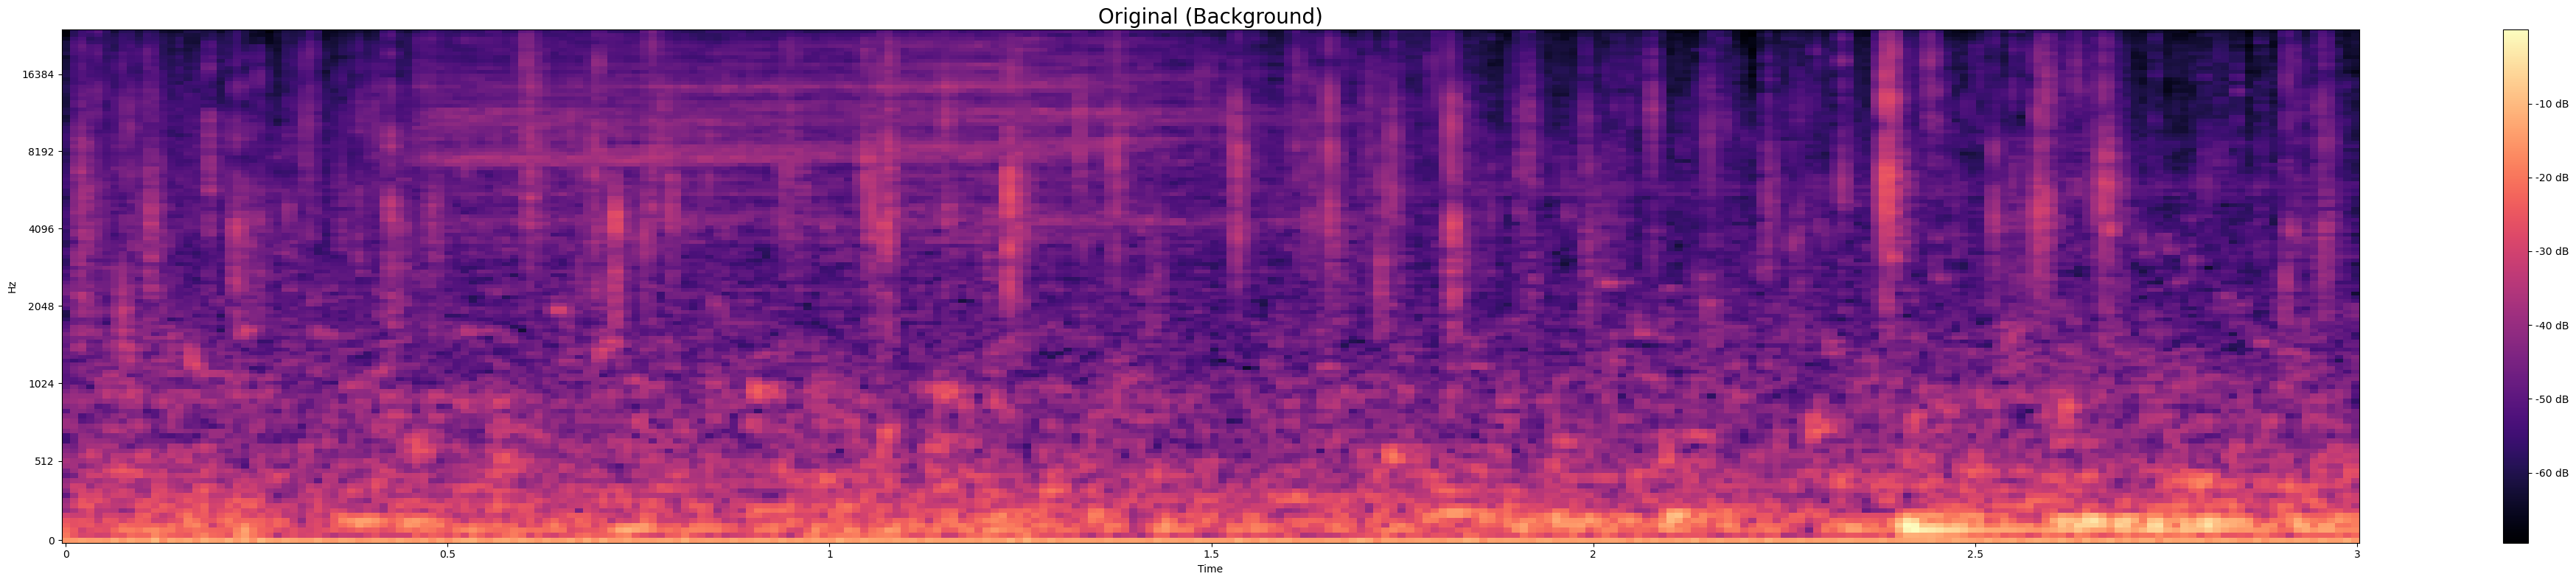

In [31]:
# Plot the spectrogram of one file
# Load the audio file
sample_file = df_wopam_day['FilePath'][0]

signal, sr = librosa.load(sample_file, sr=48000)

# preprocess the audio
signal = preprocess_audio(sample_file, target_sr=48000, duration=3)

# Mel spectrograms
mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=48000)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Visualize mel spectrogram
plt.figure(figsize=(40, 8))
plt.subplot(1, 1, 1)
librosa.display.specshow(mel_spectrogram, sr=48000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original ({df_wopam_day["Class"][0]})', fontsize=20)
plt.tight_layout()

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 MEL_SPEC1 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                                  
 MEL_SPEC2 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                              

In [33]:
input_audio.shape

NameError: name 'input_audio' is not defined

In [ ]:
# Function to preprocess audio and recreate the spectrogram
def preprocess_audio_and_compute_spectrogram(audio, sample_rate=48000, fmin=0, fmax=15000, n_mels=96, frame_length=1024, frame_step=280):

    # Normalize the audio to be between -1 and 1
    audio = (audio - np.min(audio)) / (np.max(audio) - np.min(audio)) * 2 - 1

    # Convert audio to a TensorFlow tensor
    audio_tensor = tf.convert_to_tensor(audio, dtype=tf.float32)

    # Mel Filterbank
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=frame_length // 2 + 1,
        sample_rate=sample_rate,
        lower_edge_hertz=fmin,
        upper_edge_hertz=fmax,
        dtype=tf.float32
    )

    # Perform the STFT (Short Time Fourier Transform)
    stft = tf.signal.stft(audio_tensor, frame_length=frame_length, frame_step=frame_step, fft_length=frame_length, window_fn=tf.signal.hann_window)

    # Cast from complex to float
    magnitude = tf.abs(stft)

    # Apply the Mel filterbank to the STFT result
    mel_spec = tf.tensordot(magnitude, mel_filterbank, 1)

    # Convert to power spectrogram
    mel_spec = mel_spec ** 2

    # Non-linear scaling
    mag_scale = 1.23
    mel_spec = mel_spec ** (1.0 / (1.0 + tf.exp(mag_scale)))

    # Flip the spectrogram horizontally (time axis)
    mel_spec = tf.reverse(mel_spec, axis=[2])

    # Transpose to match the shape [batch, time, mel_bins]
    mel_spec = tf.transpose(mel_spec, perm=[0, 2, 1])

    # Add a channel dimension (if needed)
    mel_spec = tf.expand_dims(mel_spec, -1)

    return mel_spec.numpy()  # Convert to NumPy array for visualization

input_audio_path = df_wopam_day['FilePath'][0]

In [ ]:
df_wopam_day[df_wopam_day["Class"] == "Whistle"]

FilePath  \
150  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
151  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
152  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
153  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
154  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   
155  ../../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/...   

                                                  File    Class  Duration  \
150  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   
151  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   
152  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   
153  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   
154  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   
155  ../../Dataset/Audios/SEANIMALMOVE/WOPAMDay/Whi...  Whistle       3.0   

                     Origin Subset   Set  
150  SEANIMALMOVE WOPAM Day   test  Test  
151  SEANIMALMOVE WOPAM Day   test  Test  
152  SEANIMALMOVE WOPAM Day   test  Test  
153  SEANIMALMOVE WOPAM Day   test  Test  
154  SEANIMALMOVE WOPAM Day   test  Test  
155  SEANIMALMOVE WOPAM Day   test  Test

1/1 [==============================] - 0s 186ms/step


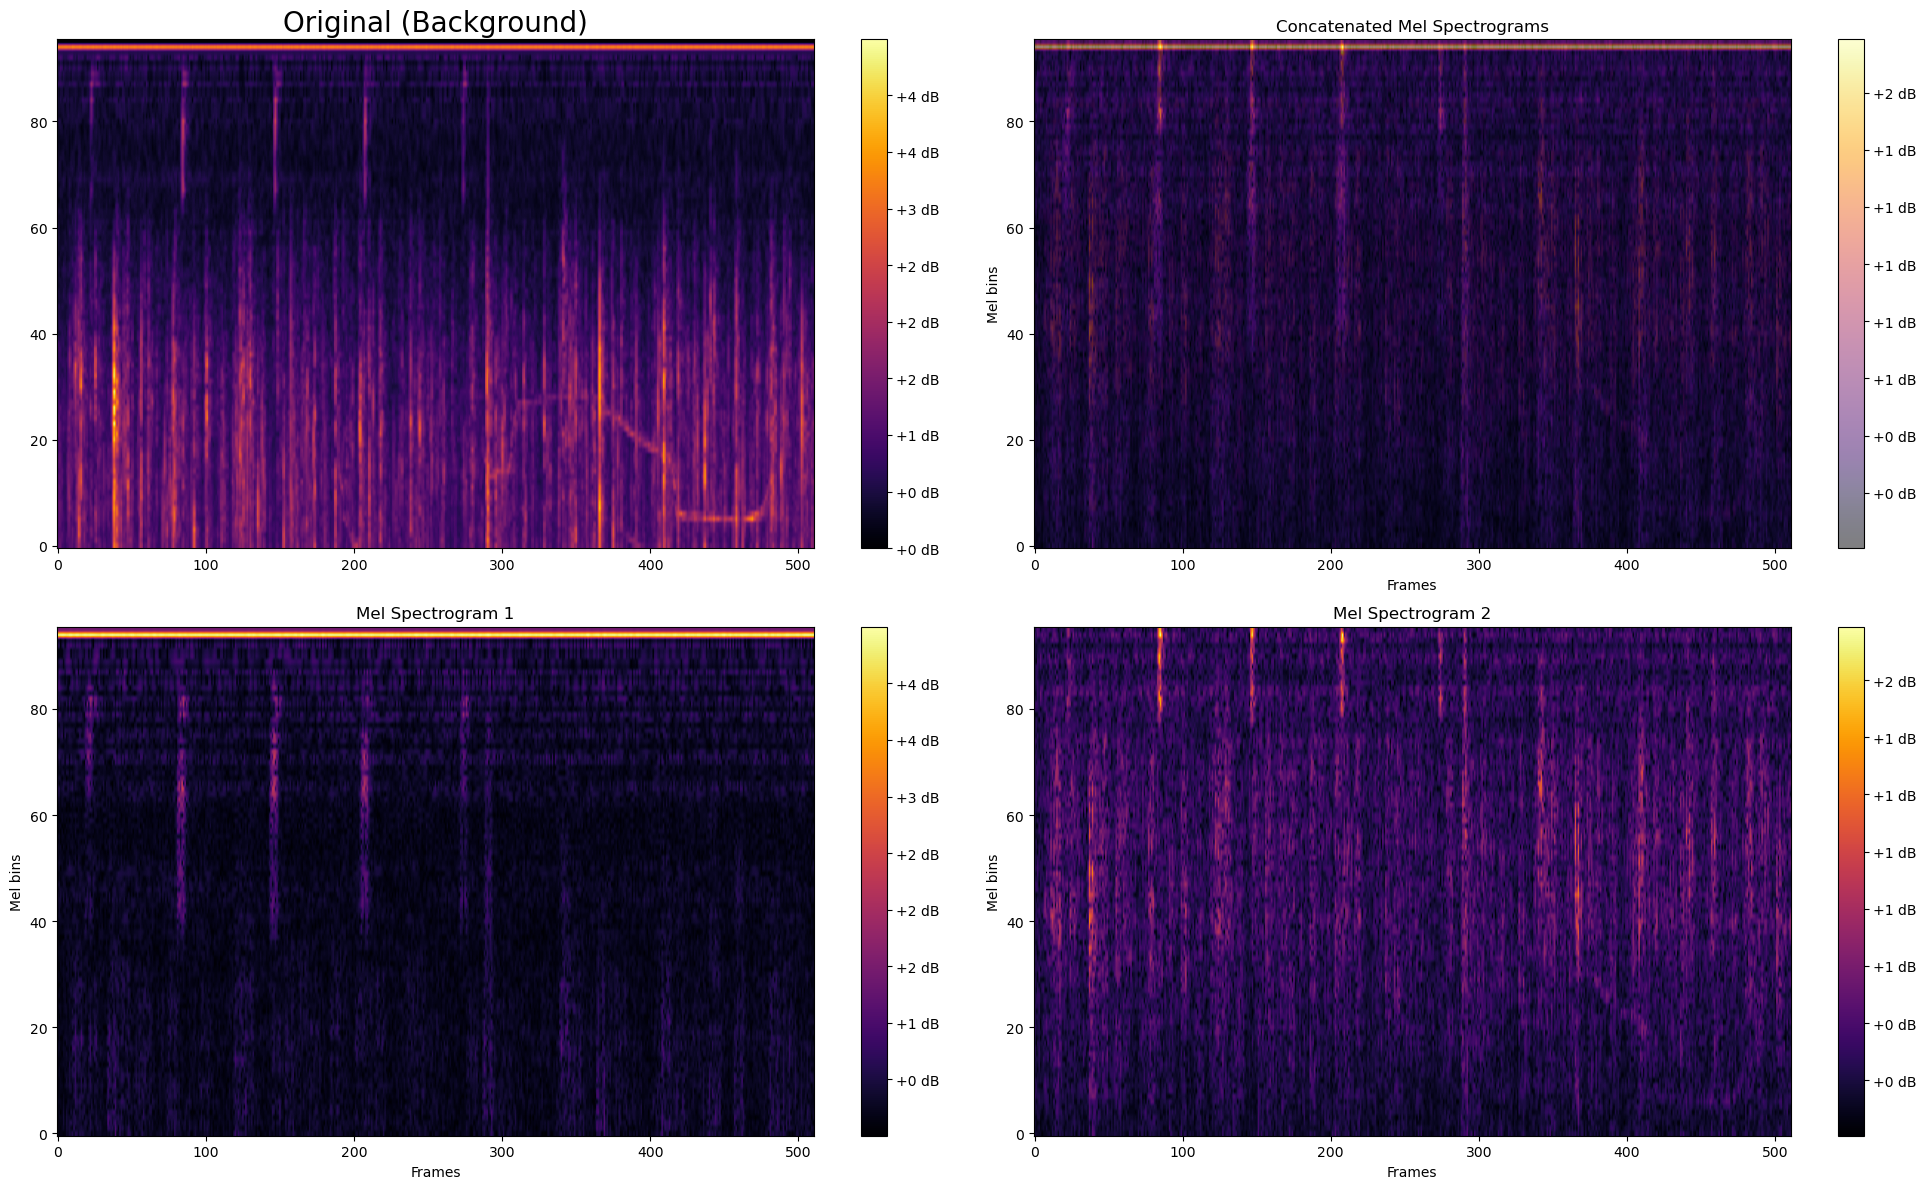

In [ ]:
intermediate_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer('MEL_SPEC1').output, model.get_layer('MEL_SPEC2').output])

input_audio_path = df_wopam_day['FilePath'][153]

# preprocess the audio
input_audio_original = preprocess_audio(input_audio_path, target_sr=48000, duration=3)

# Reshape the input audio to match the expected input shape of the model
input_audio = np.expand_dims(input_audio_original, axis=0)

# Perform a forward pass through the model to get the intermediate outputs (MEL_SPEC1 and MEL_SPEC2)
mel_spec1, mel_spec2 = intermediate_model.predict(input_audio)

mel_spec = preprocess_audio_and_compute_spectrogram(input_audio)

# Concatenate the spectrograms (as the model does before passing to the next layer)
concatenated_spec = np.concatenate([mel_spec1[0][..., np.newaxis], mel_spec2[0][..., np.newaxis]], axis=-1)

# Create a figure with 4 plots
plt.figure(figsize=(20, 12))

# Visualize original mel spectrogram
plt.subplot(2, 2, 1)
# librosa.display.specshow(mel_spec[0, :, :, 0])
plt.imshow(mel_spec[0], aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original ({df_wopam_day["Class"][0]})', fontsize=20)

# concatenated_spec = np.concatenate([mel_spec1, mel_spec2], axis=-1)

# Concatenate the spectrograms (as the model does before passing to the next layer)
concatenated_spec = np.concatenate([mel_spec1[0][..., np.newaxis], mel_spec2[0][..., np.newaxis]], axis=-1)

# Plot concatenated spectrograms
plt.subplot(2, 2, 2)
plt.imshow(concatenated_spec[..., 0], aspect='auto', origin='lower', cmap='inferno')
plt.imshow(concatenated_spec[..., 1], aspect='auto', origin='lower', cmap='inferno', alpha=0.5)
plt.title("Concatenated Mel Spectrograms")
plt.colorbar(format="%+2.0f dB")
plt.xlabel('Frames')
plt.ylabel('Mel bins')

# Plot Mel Spectrogram 1
plt.subplot(2, 2, 3)
plt.imshow(mel_spec1[0], aspect='auto', origin='lower', cmap='inferno')  # Remove batch dimension
plt.title("Mel Spectrogram 1")
plt.colorbar(format="%+2.0f dB")
plt.xlabel('Frames')
plt.ylabel('Mel bins')

# Plot Mel Spectrogram 2
plt.subplot(2, 2, 4)
plt.imshow(mel_spec2[0], aspect='auto', origin='lower', cmap='inferno')  # Remove batch dimension
plt.title("Mel Spectrogram 2")
plt.colorbar(format="%+2.0f dB")
plt.xlabel('Frames')
plt.ylabel('Mel bins')

plt.tight_layout()
plt.show()

In [ ]:
# print model -6 layer
model.layers[-6].name

'POST_ACT_1'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import librosa.display

# load model
model = tf.keras.models.load_model(f"../Models/{EXPERIMENT}/")

def make_gradcam_heatmap(spectrogram, model, last_conv_layer_name, pred_index=None):
    """
    Create Grad-CAM heatmap for a given spectrogram input.
    
    Arguments:
    spectrogram -- The Mel spectrogram input for which we want the Grad-CAM heatmap.
    model -- The model which has the last convolutional layer we want to use.
    last_conv_layer_name -- The name of the last convolutional layer in the model.
    pred_index -- The predicted class index. If None, the most probable class is used.
    
    Returns:
    heatmap -- The Grad-CAM heatmap.
    class_pred -- The predicted class index.
    confidence -- The confidence of the prediction.
    """
    
    # Crear un modelo intermedio con la capa convolucional deseada
    grad_model = Model(
        inputs=model.inputs, 
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(spectrogram)
        pred_index = pred_index or tf.argmax(preds[0])  # Índice de la clase predicha
        class_channel = preds[:, pred_index]  # Salida asociada a la clase predicha

    # Calcular gradientes
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Pooling global sobre las dimensiones espaciales
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiplicación elemento a elemento en lugar de matricial
    last_conv_layer_output = last_conv_layer_output[0] * pooled_grads
    
    # Normalizar el heatmap
    heatmap = tf.reduce_mean(last_conv_layer_output, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)

    return heatmap.numpy(), int(pred_index.numpy()), float(preds[0][pred_index].numpy())


def gradcam_spectrogram_size(spectrogram, heatmap):
    """
    Resize the Grad-CAM heatmap to match the spectrogram shape.
    """
    
    # Escalar el heatmap a 0-255
    heatmap = np.uint8(255 * heatmap)
    jet = plt.get_cmap("inferno")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Redimensionar heatmap al tamaño del espectrograma
    jet_heatmap = tf.image.resize(jet_heatmap, (spectrogram.shape[0], spectrogram.shape[1]))
    jet_heatmap = np.squeeze(jet_heatmap)
    
    return jet_heatmap

def compute_gradcam_spectrogram(model_path ="../Models/31_WhistleUpsampleHumanDiver/", input_audio_path = df_wopam_day['FilePath'][152], last_conv_layer_name='POST_CONV_1'):
    """
    Compute the Grad-CAM heatmap for a given audio file."
    """
    
    model = tf.keras.models.load_model(model_path)

    input_audio_original = preprocess_audio(input_audio_path, target_sr=48000, duration=3)
    input_audio = np.expand_dims(input_audio_original, axis=0)

    # Obtener el heatmap y predicción
    heatmap, class_pred, confidence = make_gradcam_heatmap(input_audio, model, last_conv_layer_name)

    # Obtener espectrogramas intermedios
    intermediate_model = tf.keras.Model(inputs=model.input, 
                                        outputs=[model.get_layer('MEL_SPEC1').output, model.get_layer('MEL_SPEC2').output])
    mel_spec1, mel_spec2 = intermediate_model.predict(input_audio)

    # Concatenar espectrogramas
    concatenated_spec = np.concatenate([mel_spec1[0], mel_spec2[0]], axis=-1)
    concatenated_spec = np.mean(concatenated_spec, axis=-1)  # Reducir dimensiones

    # Redimensionar heatmap
    gradcam_output = gradcam_spectrogram_size(concatenated_spec, heatmap)

    # Mostrar gráficos
    plt.figure(figsize=(20, 10))

    # Mel-Spectrogram 1
    plt.subplot(3, 2, 1)
    plt.imshow(mel_spec1[0], cmap='inferno', origin='lower')
    plt.axis('off')
    plt.title("Mel Spectrogram 1 (Low Frequencies)")

    # Mel-Spectrogram 2
    plt.subplot(3, 2, 2)
    plt.imshow(mel_spec2[0], cmap='inferno', origin='lower')
    plt.axis('off')
    plt.title("Mel Spectrogram 2 (High Frequencies")

    # Heatmap overlay sobre cada espectrograma
    plt.subplot(3, 2, 3)
    plt.imshow(mel_spec1[0], cmap='inferno', origin='lower')
    plt.imshow(gradcam_output, cmap='jet', alpha=0.5, origin='lower')
    plt.axis('off')
    plt.title("Grad-CAM on Mel Spectrogram 1")

    plt.subplot(3, 2, 4)
    plt.imshow(mel_spec2[0], cmap='inferno', origin='lower')
    plt.imshow(gradcam_output, cmap='jet', alpha=0.5, origin='lower')
    plt.axis('off')
    plt.title("Grad-CAM on Mel Spectrogram 2")

    # Heatmap aislado
    plt.subplot(3, 2, 5)
    plt.imshow(gradcam_output, cmap='jet', origin='lower')
    plt.axis('off')
    plt.title("Grad-CAM heatmap")

    # Mostrar predicción y confianza
    plt.subplot(3, 2, 6)
    # if class_pred = 0 Background, if 1 Whistle
    predicted_class = "Whistle" if class_pred == 1 else "Background"
    plt.text(0.5, 0.5, f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}", 
            fontsize=20, ha='center', va='center')
    plt.axis('off')

    plt.show()

: 

In [ ]:
sample_whistle = df_wopam_day[df_wopam_day["Class"] == "Whistle"]
filepath = df_wopam_day['FilePath'][153]
sample_whistle = sample_whistle.reset_index(drop=True)
sample_whistle = sample_whistle["FilePath"][4]

NameError: name 'df_wopam_day' is not defined

1/1 [==============================] - 0s 273ms/step


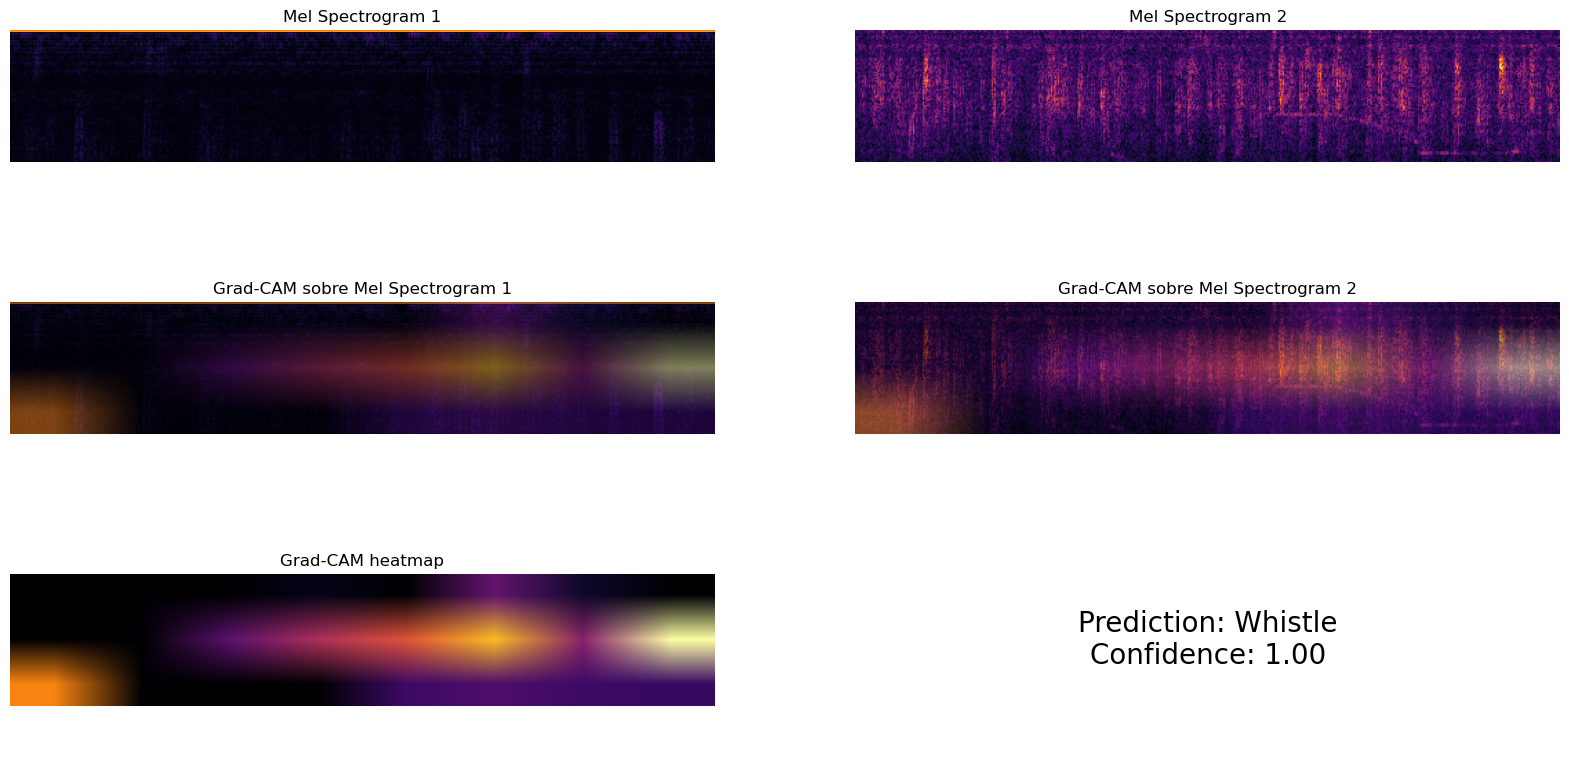

In [ ]:
compute_gradcam_spectrogram(input_audio_path = sample_whistle, last_conv_layer_name='BLOCK_4-4_CONV_3')

In [101]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, 144000)]             0         []                            
                                                                                                  
 MEL_SPEC1 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                                  
 MEL_SPEC2 (MelSpecLayerSim  (None, 96, 511, 1)           1         ['INPUT[0][0]']               
 ple)                                                                                             
                                                                                              

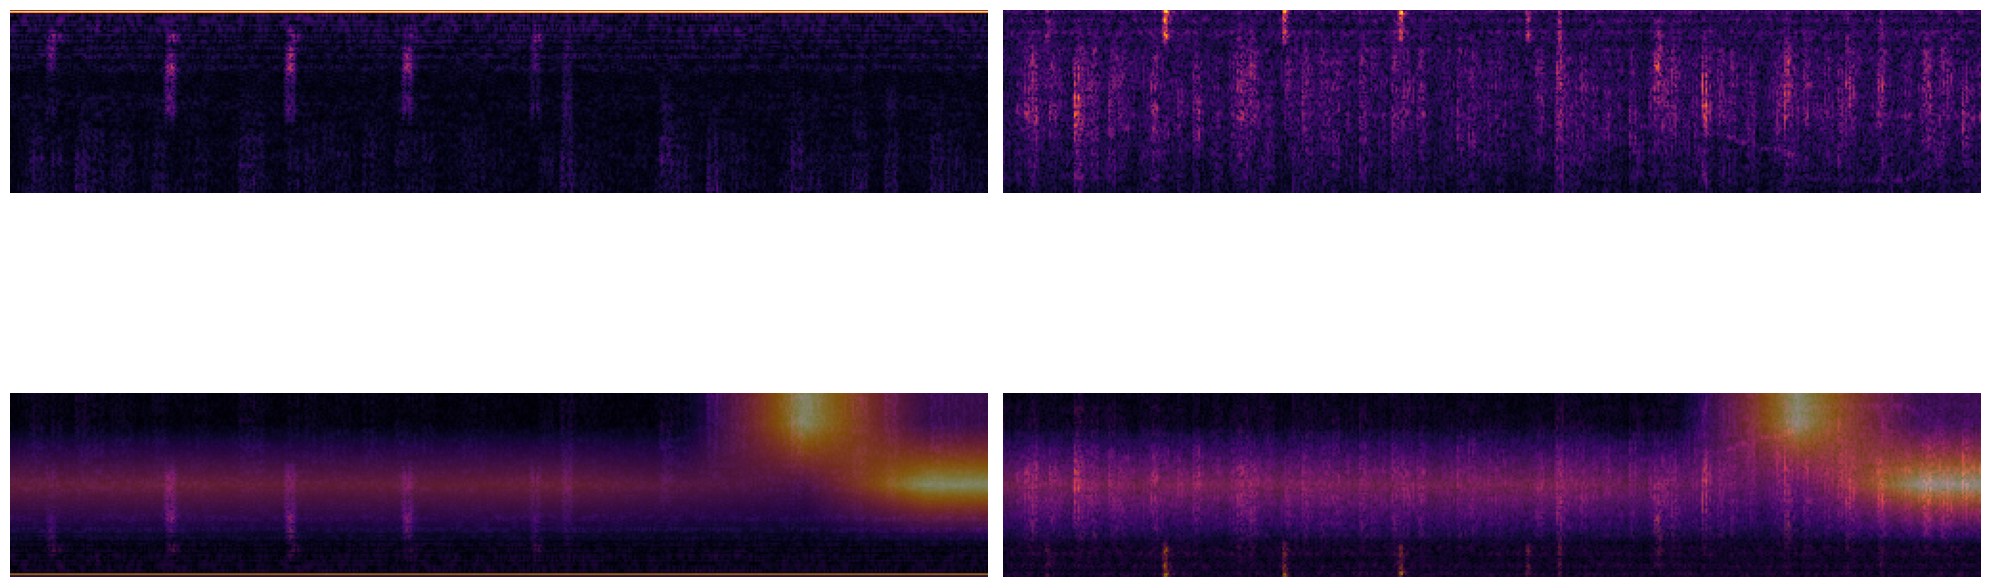

In [49]:
# Display specrtrogram and heatmap
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.imshow(mel_spec1[0], cmap='inferno', origin='lower')
# plt.title('Concatenated Mel Spectrogram')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(mel_spec2[0], cmap='inferno', origin='lower')
# plt.title('Concatenated Mel Spectrogram')
plt.axis('off')

# Display specttrogram and then heatmap at alpha 0.5
plt.subplot(2, 2, 3)
plt.imshow(mel_spec1[0], cmap='inferno', origin='lower')
plt.imshow(gradcam_output, cmap='inferno', alpha=0.5)
# plt.title('Concatenated Mel Spectrogram')
plt.axis('off')

# Display specttrogram and then heatmap at alpha 0.5
plt.subplot(2, 2, 4)
plt.imshow(mel_spec2[0], cmap='inferno', origin='lower')
plt.imshow(gradcam_output, cmap='inferno', alpha=0.5)
# plt.title('Concatenated Mel Spectrogram')
plt.axis('off')

plt.tight_layout()
plt.show()